In [1]:
from typing import Sequence, Dict, Optional
import numpy as np


def simulate_time_to_target(
    daily_growth_samples: Sequence[float],
    current_followers: int,
    target_followers: int = 100_000,
    max_days: int = 3650,
    rng: Optional[np.random.Generator] = None,
) -> int:
    """
    Simuliere, wie viele Tage es dauert, bis die Ziel-Followerzahl erreicht ist,
    indem du jeden Tag ein Wachstum zufällig aus den letzten N Tagen ziehst
    (Bootstrapping der historischen Wachstumsraten).
    """
    if rng is None:
        rng = np.random.default_rng()

    samples = np.array(daily_growth_samples, dtype=float)
    if samples.size == 0:
        raise ValueError("daily_growth_samples must not be empty")

    if current_followers >= target_followers:
        return 0

    followers = current_followers
    days = 0

    while followers < target_followers and days < max_days:
        daily_growth = rng.choice(samples)
        followers += daily_growth
        days += 1

    # Wenn max_days erreicht ist, geben wir max_days zurück (heißt: Ziel nicht erreicht)
    return days


def estimate_days_to_target(
    daily_growth_samples: Sequence[float],
    current_followers: int,
    target_followers: int = 100_000,
    n_simulations: int = 10_000,
    max_days: int = 3650,
    random_seed: Optional[int] = None,
) -> Dict[str, float]:
    """
    Führe viele Simulationen durch und gib Statistik zurück:
    - erwartete Tage
    - Median
    - 10%- und 90%-Quantil
    """
    rng = np.random.default_rng(random_seed)

    results = np.empty(n_simulations, dtype=int)
    for i in range(n_simulations):
        results[i] = simulate_time_to_target(
            daily_growth_samples=daily_growth_samples,
            current_followers=current_followers,
            target_followers=target_followers,
            max_days=max_days,
            rng=rng,
        )

    return {
        "expected_days": float(results.mean()),
        "median_days": float(np.median(results)),
        "p10_days": float(np.percentile(results, 10)),
        "p90_days": float(np.percentile(results, 90)),
    }


## Running the Monte Carlo (Put in your data)

In [2]:

current_followers = 55000 # Change this
last_10_days_growth = [1057, 1224, 1071, 1186, 1330, 958, 663, 612, 475, 726]  # Change this

stats = estimate_days_to_target(
    daily_growth_samples=last_10_days_growth,
    current_followers=current_followers,
    target_followers=100000,
    n_simulations=1000,
    max_days=365,
    random_seed=42,
)

stats


{'expected_days': 48.92,
 'median_days': 49.0,
 'p10_days': 46.0,
 'p90_days': 52.0}

## Histrogram Plot

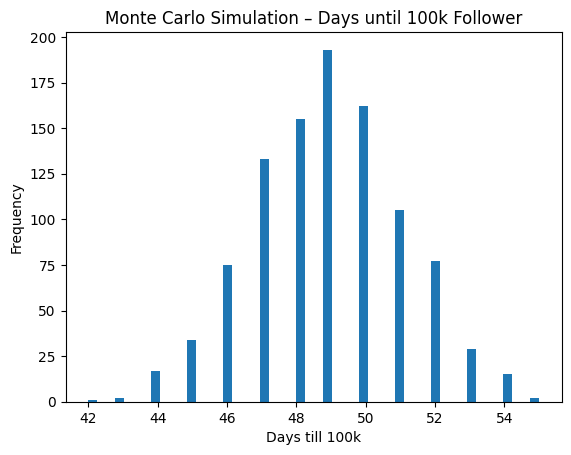

In [3]:
import matplotlib.pyplot as plt
import numpy as np

n_simulations = 1000
rng = np.random.default_rng(42)

results = np.array([
    simulate_time_to_target(
        daily_growth_samples=last_10_days_growth,
        current_followers=current_followers,
        target_followers=100_000,
        max_days=365,
        rng=rng,
    )
    for _ in range(n_simulations)
])

plt.hist(results, bins=50)
plt.xlabel("Days till 100k")
plt.ylabel("Frequency")
plt.title("Monte Carlo Simulation – Days until 100k Follower")
plt.show()


## Probability of Reaching 100k in X days

In [7]:
# Choose the horizon X (in days)
target_days = 50  # e.g. 1 year

# Probability of reaching 100k within X days
prob_reach = np.mean(results <= target_days)

print(f"Probability of reaching 100k within {target_days} days: {prob_reach:.2%}")


Probability of reaching 100k within 50 days: 77.20%
